In [1]:
import numpy as np
from astropy.io import fits
from astropy import units
from astropy.table import Table, join
import astropy.coordinates as coord
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from tqdm import tqdm
from scipy.stats import multivariate_normal, norm
import tensorflow as tf
import corner
import matplotlib.pyplot as plt
import os
import pickle
import define_rgbtgassample
import pickle
import statsmodels.api as sm
import apogee.tools.read as apread
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import safe_colours
from astroNN.datasets import H5Compiler, H5Loader, xmatch
from astroNN.models import ApogeeBCNN
lowess= sm.nonparametric.lowess
safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cols = safe_colours.distinct_list(3)
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging') 


params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 14, 'font.family': 'serif'}
plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/astjmack/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/astjmack/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:

# To create a astroNN compiler instance
compiler = H5Compiler()

# To set the name of the resulting h5 datasets, here a 'test.h5' will be created
compiler.filename = 'test'

 # Gaia DR to use, Default is 1
compiler.starflagcut = False  # True to filter out ASPCAP star flagged spectra
compiler.aspcapflagcut = False  # True to filter out ASPCAP flagged spectra
compiler.vscattercut = 1  # Upper bound of velocity scattering
compiler.teff_high = 9000  # Upper bound of SNR
compiler.teff_low = 2000  # Lower bound of SNR
compiler.SNR_low = 80  # Lower bound of SNR
compiler.SNR_high = 99999  # Upper bound of SNR
compiler.use_esa_gaia = False
compiler.ironlow = -3  # Lower bound of SNR # Filename of the resulting .h5 file
compiler.spectra_only = False  # True to include spectra only without any aspcap abundances
compiler.cont_mask = None  # True to use Anderson et al 2017 parallax, **if use_esa_gaia is True, ESA Gaia will has priority**
compiler.err_info = True  # Whether to include error information in h5 dataset
compiler.continuum = True
if not os.path.isfile('test.h5'):
    compiler.compile()
else:
    loader = H5Loader('test.h5')
    loader.load_err = True  # load error info too
    x, y, x_err, y_err = loader.load()

In [3]:
#load apogee allStar file and find the indices of the spectra which are compiled
allstar = compiler.load_allstar()
indices = compiler.filter_apogeeid_list(allstar)
#load the APOKASC-2 catalogue (point the path at it!)
path = '/gal/astjmack/apogee/catalogues/APOKASC_cat_v4.4.2.fits'
napokasc = fits.open(path)
ndata = napokasc[1].data
#cross match APOKASC with the compiled APOGEE spectra
ra = loader.load_entry('RA')
dec = loader.load_entry('DEC')
ra_age = ndata['RA']
dec_age = ndata['DEC']
idx_1, idx_2, sep = xmatch(ra, ra_age, colRA1=ra, colDec1=dec, colRA2=ra_age, colDec2=dec_age, swap=True)



dr is not provided, using default dr=14
/gal/sdss_lsm/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
Loading allStar DR14 catalog
Total Combined Spectra after filtering:  183292
Total Individual Visit Spectra there:  627188


In [4]:
ages = ndata['APOKASC2_AGE'][idx_2]
age_error = ndata['APOKASC2_AGE_MERR'][idx_2]

test_spec = x[idx_1]
test_errspec = x_err[idx_1]
test_out = y[idx_1]
test_outerr  = y_err[idx_1]
test_out = np.append(ages.reshape(len(ages),1),test_out, axis=1)
test_outerr = np.append(age_error.reshape(len(ages),1),test_outerr, axis=1)

In [5]:
mask = np.all(np.isfinite(test_out), axis=1) & np.all(np.isfinite(test_outerr), axis=1) & (test_out[:,3] > -0.5) & (test_out[:,0] != -9999.) & (test_out[:,0] < 13.5) 
print('number of training stars: '+str(sum(mask)))
test_inds = np.random.choice(np.arange(0,len(test_spec[mask])),size=300, replace=False)
test_mask = np.zeros(len(test_spec[mask]), dtype=bool)
test_mask[test_inds] = True
print('number of test stars: '+str(sum(test_mask)))

number of training stars: 5936
number of test stars: 300


In [6]:
#Set up the BCNN
# create an instance of Bayesian Convolutional Neural Network class
bcnn_net = ApogeeBCNN()

bcnn_net.task = 'regression'
bcnn_net.labels_shape=26
bcnn_net.num_hidden = [128,64]
bcnn_net.batch_size = 32

#set number of training epochs - 60 seems to be enough!
bcnn_net.max_epochs = 60

In [7]:
#Now do the training (removing the test stars!)
bcnn_net.train(test_spec[mask][~test_mask],test_out[mask][~test_mask], test_errspec[mask][~test_mask], test_outerr[mask][~test_mask]) #, test_errspec[mask],out_err[mask])

Number of Training Data: 5073, Number of Validation Data: 563
====Message from Normalizer====
You selected mode: 3
Featurewise Center: True
Datawise Center: False
Featurewise std Center: False
Datawise std Center: False
====Message ends====
====Message from Normalizer====
You selected mode: 2
Featurewise Center: True
Datawise Center: False
Featurewise std Center: True
Datawise std Center: False
====Message ends====
/home/astjmack/anaconda3/lib/python3.6/site-packages/astroNN-1.1.dev0-py3.6.egg/astroNN/nn/utilities/normalizer.py:110: RuntimeWarning: divide by zero encountered in true_divide
  data_array /= self.std_labels

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Epoch 1/60
 - 8s - loss: 0.1276 - output_loss: 0.1276 - variance_output_loss: 0.1276 - output_mean_absolute_error: 0.5597 - output_mean_error: 0.0271 - val_loss: -1.6519e-01 - val_output_loss: -1.6520e-01 - val_variance_output_loss: -1.6520e-01 - val_output_mean_absolute_error: 0.4141 -

Epoch 23/60
 - 7s - loss: -7.4717e-01 - output_loss: -7.4718e-01 - variance_output_loss: -7.4718e-01 - output_mean_absolute_error: 0.2482 - output_mean_error: 0.0017 - val_loss: -6.3432e-01 - val_output_loss: -6.3434e-01 - val_variance_output_loss: -6.3434e-01 - val_output_mean_absolute_error: 0.2682 - val_output_mean_error: 0.0051
Epoch 24/60
 - 8s - loss: -7.3552e-01 - output_loss: -7.3554e-01 - variance_output_loss: -7.3554e-01 - output_mean_absolute_error: 0.2528 - output_mean_error: 0.0024 - val_loss: -5.8383e-01 - val_output_loss: -5.8385e-01 - val_variance_output_loss: -5.8385e-01 - val_output_mean_absolute_error: 0.2704 - val_output_mean_error: 0.0044

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/60
 - 8s - loss: -7.5767e-01 - output_loss: -7.5769e-01 - variance_output_loss: -7.5769e-01 - output_mean_absolute_error: 0.2479 - output_mean_error: 0.0022 - val_loss: -6.5083e-01 - val_output_loss: -6.5084e-01 - val_variance_output_loss: -6

Epoch 46/60
 - 8s - loss: -7.7476e-01 - output_loss: -7.7478e-01 - variance_output_loss: -7.7478e-01 - output_mean_absolute_error: 0.2444 - output_mean_error: 0.0023 - val_loss: -6.5479e-01 - val_output_loss: -6.5481e-01 - val_variance_output_loss: -6.5481e-01 - val_output_mean_absolute_error: 0.2582 - val_output_mean_error: 0.0098

Epoch 00046: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 47/60
 - 7s - loss: -7.8127e-01 - output_loss: -7.8129e-01 - variance_output_loss: -7.8129e-01 - output_mean_absolute_error: 0.2437 - output_mean_error: 0.0021 - val_loss: -6.6974e-01 - val_output_loss: -6.6976e-01 - val_variance_output_loss: -6.6976e-01 - val_output_mean_absolute_error: 0.2657 - val_output_mean_error: 0.0062
Epoch 48/60
 - 8s - loss: -7.8163e-01 - output_loss: -7.8164e-01 - variance_output_loss: -7.8164e-01 - output_mean_absolute_error: 0.2430 - output_mean_error: 0.0023 - val_loss: -7.0526e-01 - val_output_loss: -7.0527e-01 - val_variance_output_loss: -7

In [8]:
#generate predictions from trained model (then save to file)
pred, pred_std = bcnn_net.test(test_spec, test_errspec)

with open('../sav/astroNN_Bayes_APOKASC_predictions.npy', 'wb') as f:
    np.save(f, pred)
    np.save(f, pred_std)

predrec = np.recarray(len(apo_ra[apo_idx_2][goodmask]), dtype=[('APOGEE_ID', '<U18'),
                                                               ('APOKASC2_AGE', float),
                                                               ('APOKASC2_AGE_MERR', float)
                                                               ('astroNN_age', float),
                                                               ('astroNN_age_total_std', float),
                                                               ('astroNN_age_predictive_std', float),
                                                               ('astroNN_age_model_std', float)])

predrec['APOGEE_ID'] = ndata['APOGEE_ID'][idx_2]
predrec['APOKASC2_AGE'] = ndata['APOKASC2_AGE'][idx_2]
predrec['APOKASC2_AGE_MERR'] = ndata['APOKASC2_AGE_MERR'][idx_2]
predrec['astroNN_age'] = pred[:,0][idx_1]
predrec['astroNN_age_total_std'] = pred_std['total'][:,0][idx_1]
predrec['astroNN_age_predictive_std'] = pred_std['predictive'][:,0][idx_1]
predrec['astroNN_age_model_std'] = pred_std['model'][:,0][idx_1]

hdu = fits.BinTableHDU.from_columns(agerec)
hdu.writeto('../sav/astroNN_Bayes_APOKASC_predictions.fits')

/home/astjmack/anaconda3/lib/python3.6/site-packages/astroNN-1.1.dev0-py3.6.egg/astroNN/models/BayesianCNNBase.py:344: UserWarning: You are using CPU version Tensorflow, doing 100 times Monte Carlo Inference can potentially be very slow! 
 A possible fix is to decrease the mc_num parameter of the model to do less MC Inference 
This is just a warning, and will not shown if mc_num < 25 on CPU
  warnings.warn(f'You are using CPU version Tensorflow, doing {self.mc_num} times Monte Carlo Inference can '

Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 383.99s elapsed


/home/astjmack/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "



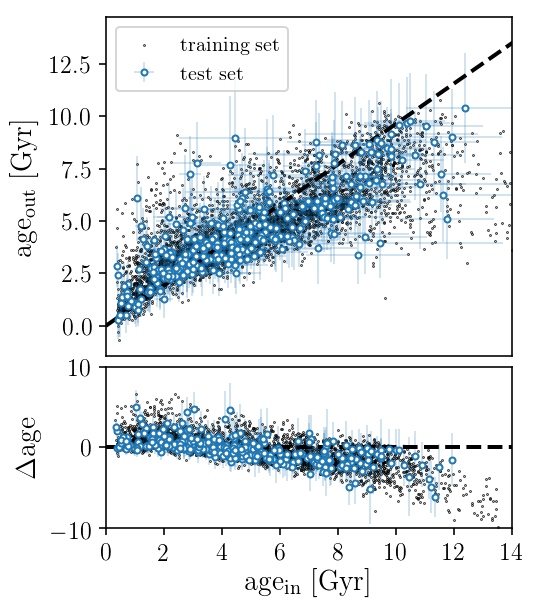

In [9]:
# plot the prediction vs the training set
i = 0
fig = plt.figure()
fig.set_size_inches(columnwidth,1.2*columnwidth)
ax = fig.add_axes([0.1,0.4,0.85,0.59])
ax1 = fig.add_axes([0.1,0.1,0.85,0.28])
ax.scatter(test_out[:,i][mask], pred[:,i][mask], s=0.1, c='Black', label=r'$\mathrm{training\ set}$',rasterized=True)
ax.errorbar(test_out[:,i][mask][test_mask], pred[:,i][mask][test_mask], yerr=pred_std['total'][:,i][mask][test_mask], xerr=test_outerr[:,i][mask][test_mask], fmt='o', ms=3., markerfacecolor='white', label=r'$\mathrm{test\ set}$', elinewidth=0.2,)

ax.plot([0.,14.], [0.,14.], linestyle='dashed', color='Black', linewidth=2.)
ax.legend()
ax.set_ylabel(r'$\mathrm{age_{out}\ [Gyr]}$')
ax.set_xticks([])
ax1.scatter(test_out[:,0][mask], (pred[:,0][mask]-test_out[:,0][mask]), s=0.1, color='Black', rasterized=True)
ax1.errorbar(test_out[:,0][mask][test_mask], (pred[:,0][mask][test_mask]-test_out[:,0][mask][test_mask]),yerr=np.sqrt((pred_std['total'][:,i][mask][test_mask])**2+(test_outerr[:,i][mask][test_mask])**2), fmt='o', ms=3., markerfacecolor='white', label=r'$\mathrm{test\ set}$', elinewidth=0.2,)
ax1.axhline(0., linestyle='dashed',color='Black', linewidth=2.)
ax1.set_ylabel(r'$\Delta\mathrm{age}$')
ax1.set_xlabel(r'$\mathrm{age_{in}\ [Gyr]}$')
ax1.set_ylim(-10,10)
fig.tight_layout()
ax.set_xlim(0.,13.5,)
ax1.set_xlim(0.,13.5)
ax1.set_xticks([0.,2.,4.,6.,8.,10.,12.,14.])

#plt.savefig('../plots/astroNNbayes_agein_ageout.pdf', format='pdf', dpi=400, bbox_inches='tight')
#plt.savefig('../plots/astroNNbayes_agein_ageout.png', format='png', dpi=400,  bbox_inches='tight')




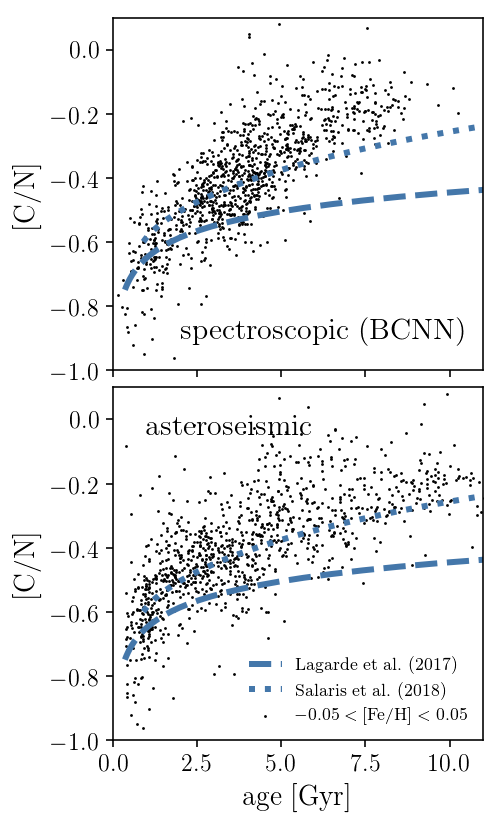

In [10]:
#plot the [C/N]-age relationships from the spectroscopic and asteroseismic ages, and compare with Salaris and Lagarde models.
fig, ax  = plt.subplots(2,1, sharex=True)
fig.set_size_inches(columnwidth,2*columnwidth)

#plot spectroscopic age-[C/N]
tmask = (ndata['FE_H'][idx_2][mask] > -0.05) & (ndata['FE_H'][idx_2][mask] < 0.05)
ax[0].scatter(pred[:,0][mask][tmask],ndata['C_FE'][idx_2][mask][tmask]-ndata['N_FE'][idx_2][mask][tmask], s=2, lw=0, c='Black', label=r'$\mathrm{test\ set}$',rasterized=True)

#plot models
ys = np.linspace(-0.75,0.4,100)
xs = 1.317*ys**2+6.329*ys+12.56
xs = 10**(xs)/1e9
ax[0].plot(xs,ys, lw=3., linestyle='dashed', color=cols[0], label=r'$\mathrm{Lagarde\ et\ al.\ (2017)}$')

ys = np.linspace(-0.6,0.4,100)
xs = 34.99+156.3*ys+298.6*ys**2+305.9*ys**3+141*ys**4
ax[0].plot(xs,ys, lw=3., linestyle='dotted', color=cols[0], label=r'$\mathrm{Salaris\ et\ al.\ (2018)}$')

ax[0].set_ylabel(r'$\mathrm{[C/N]}$')
ax[0].set_ylim(-1.,0.1)
ax[0].set_xlim(0.,11.)

#plot asteroseismic age-[C/N]
ax[1].scatter(ndata['APOKASC2_AGE'][idx_2][mask][tmask],ndata['C_FE'][idx_2][mask][tmask]-ndata['N_FE'][idx_2][mask][tmask], s=2,lw=0., c='Black', label=r'$-0.05 < \mathrm{[Fe/H]} < 0.05$',rasterized=True)

#and models
ys = np.linspace(-0.75,0.4,100)
xs = 1.317*ys**2+6.329*ys+12.56
xs = 10**(xs)/1e9
ax[1].plot(xs,ys, lw=3., linestyle='dashed', color=cols[0], label=r'$\mathrm{Lagarde\ et\ al.\ (2017)}$')

ys = np.linspace(-0.6,0.4,100)
xs = 34.99+156.3*ys+298.6*ys**2+305.9*ys**3+141*ys**4
ax[1].plot(xs,ys, lw=3., linestyle='dotted', color=cols[0], label=r'$\mathrm{Salaris\ et\ al.\ (2018)}$')

ax[1].set_xlabel(r'$\mathrm{age}\ \mathrm{[Gyr]}$')
ax[1].set_ylabel(r'$\mathrm{[C/N]}$')
ax[1].legend(frameon=False, fontsize='small')
ax[1].set_ylim(-1.,0.1)
ax[1].set_xlim(0.,11.)
ax[1].text(1,-0.05,r'$\mathrm{asteroseismic}$', fontsize=15)
ax[0].text(2.,-0.9,r'$\mathrm{spectroscopic\ (BCNN)}$', fontsize=15)

fig.subplots_adjust(hspace=0.05)

#plt.savefig('../plots/astroNNbayes_cnrelations.pdf', format='pdf', dpi=400, bbox_inches='tight')
#plt.savefig('../plots/astroNNbayes_cnrelations.png', format='png', dpi=400,  bbox_inches='tight')



In [11]:
#predict ages for the all the APOGEE spectra which were compiled
dr14_pred, dr14_std = bcnn_net.test(x, x_err)

/home/astjmack/anaconda3/lib/python3.6/site-packages/astroNN-1.1.dev0-py3.6.egg/astroNN/models/BayesianCNNBase.py:344: UserWarning: You are using CPU version Tensorflow, doing 100 times Monte Carlo Inference can potentially be very slow! 
 A possible fix is to decrease the mc_num parameter of the model to do less MC Inference 
This is just a warning, and will not shown if mc_num < 25 on CPU
  warnings.warn(f'You are using CPU version Tensorflow, doing {self.mc_num} times Monte Carlo Inference can '

Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 4614.59s elapsed


In [ ]:
goodmask= loader.load_en

agerec = np.recarray(len(apo_ra[apo_idx_2][goodmask]), dtype=[('APOGEE_ID', '<U18'), 
                                                  ('astroNN_age', float),
                                                  ('astroNN_age_total_std', float),
                                                  ('astroNN_age_predictive_std', float),
                                                  ('astroNN_age_model_std', float)])

agerec['APOGEE_ID'] = apodat['APOGEE_ID'][apo_idx_2][goodmask]
agerec['astroNN_age'] = dr14_pred[:,0][apo_idx_1][goodmask]
agerec['astroNN_age_total_std'] = dr14_std['total'][:,0][apo_idx_1][goodmask]
agerec['astroNN_age_predictive_std'] = dr14_std['predictive'][:,0][apo_idx_1][goodmask]
agerec['astroNN_age_model_std'] = dr14_std['model'][:,0][apo_idx_1][goodmask]

hdu = fits.BinTableHDU.from_columns(agerec)
hdu.writeto('../sav/astroNNBayes_ages_goodDR14.fits')

with open('../sav/astroNNBayes_ages_goodDR14.npy', 'wb') as f:
    np.save(f, agerec)

In [11]:
import apogee.spec.plot as splot
import apogee.spec.window as apwindow
import apogee.spec.cannon as apcannon
import apogee.spec.stack as apstack
import apogee.tools.read as apread
from apogee.tools import paramIndx

In [12]:
ndata['FE_H']

array([ 0.0797106 , -0.10584786, -0.18784443, ...,  0.25984752,
       -0.13425215,  0.04524199], dtype=float32)

In [13]:
snrmask = (loader.load_entry('SNR')[idx_1][mask][~test_mask] > 200) & (ndata['FE_H'][idx_2][mask][~test_mask] > -0.05) & (ndata['FE_H'][idx_2][mask][~test_mask] < 0.05)

teffs= ndata['TEFF_COR'][idx_2][mask][~test_mask][snrmask]
loggs= ndata['LOGG_COR'][idx_2][mask][~test_mask][snrmask]
metals= ndata['FE_H'][idx_2][mask][~test_mask][snrmask]
cf, s, r= apcannon.quadfit(test_spec[mask][~test_mask][snrmask],test_errspec[mask][~test_mask][snrmask],
                           teffs-4800.,loggs-2.85,metals+0.3,
                           return_residuals=True)

In [14]:
import empca

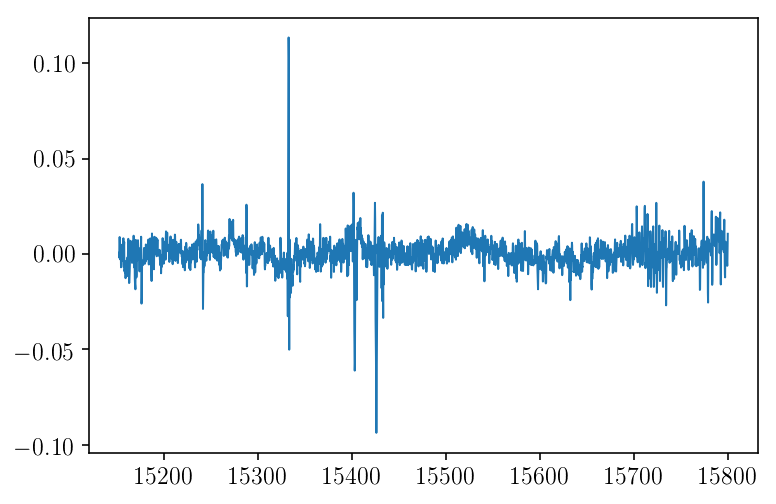

In [15]:
from astroNN.apogee.chips import wavelength_solution, chips_split
lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)
blue, green, red = chips_split(r[0], dr=14)
blue, green, red = blue[0], green[0], red[0]
plt.plot(lambda_blue, blue)

In [16]:


# Deal w/ bad data
_MAXERR= 0.02
npca= 8
pca_input= r
pca_weights= (1./test_errspec[mask][~test_mask][snrmask]**2.)
pca_weights[pca_weights < 1./_MAXERR**2.]= 0. 
nanIndx= np.isnan(pca_input) + np.isnan(pca_weights)
pca_weights[nanIndx]= 0. 
pca_input[nanIndx]= 0.
# Run EM-PCA
m= empca.empca(pca_input,pca_weights,nvec=npca,niter=25)#,silent=False)

/home/astjmack/anaconda3/lib/python3.6/site-packages/empca.py:256: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]

       iter        R2             rchi2
EMPCA  1/25       0.01762693     18.34682919
EMPCA  2/25       0.21655641     12.77700073
EMPCA  3/25       0.25351518     11.82452799
EMPCA  4/25       0.27595253     11.25065597
EMPCA  5/25       0.28991410     10.93290280
EMPCA  6/25       0.29566532     10.83618488
EMPCA  7/25       0.29791336     10.80253209
EMPCA  8/25       0.29896366     10.78494627
EMPCA  9/25       0.29963071     10.77211322
EMPCA 10/25       0.30016608     10.76122428
EMPCA 11/25       0.30062346     10.75196379
EMPCA 12/25       0.30100822     10.74454326
EMPCA 13/25       0.30133000     10.738

In [17]:

pr= np.zeros_like(r)
for jj in range(len(ndata[idx_2][mask][~test_mask][snrmask])):
    for kk in range(npca):
        pr[jj]+= m.coeff[jj,kk]*m.eigvec[kk]

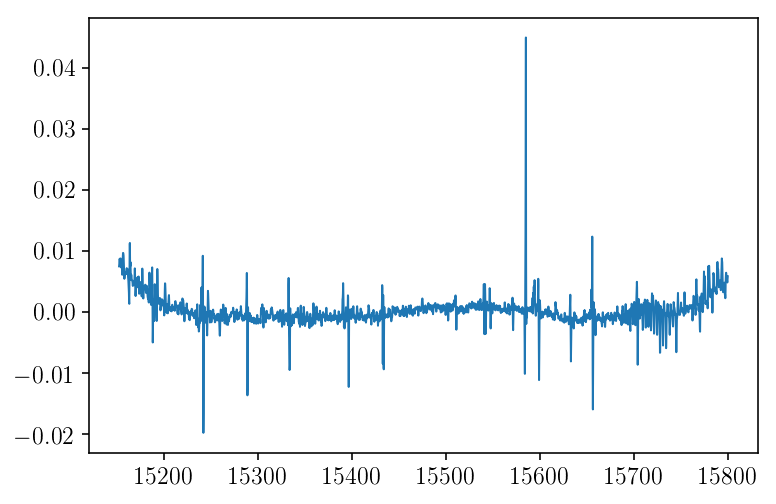

In [18]:
blue, green, red = chips_split(pr[0], dr=14)
blue, green, red = blue[0], green[0], red[0]
plt.plot(lambda_blue, blue)

In [109]:
young_agemask = (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] > 0.5) & (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] < 1.5) 
old_agemask = (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] > 10.) & (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] < 11.)
inter_agemask = (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] > 4.) & (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] < 5.) 



In [97]:
np.shape(pr[young_agemask][:10])

(10, 7514)

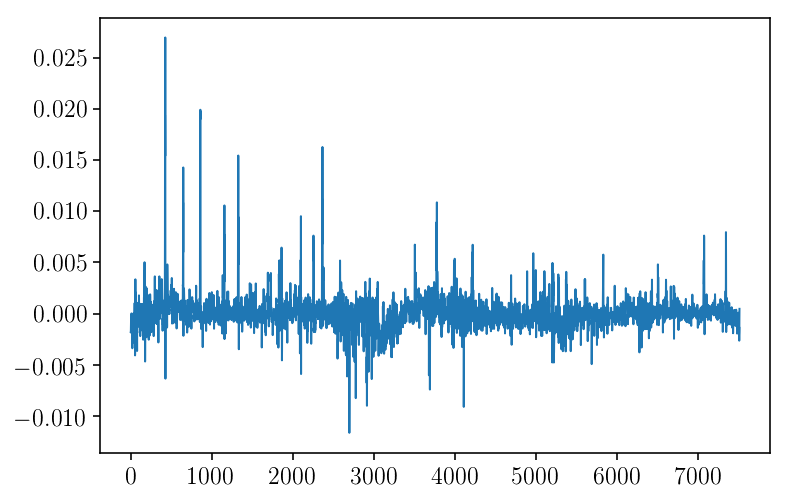

In [98]:
plt.plot(np.nanmedian(pr[young_agemask][:10], axis=0))


[ 0.  2.  4.  6.  8. 10. 12.]


[0. 2. 4. 6. 8.]


(16837, 16843)

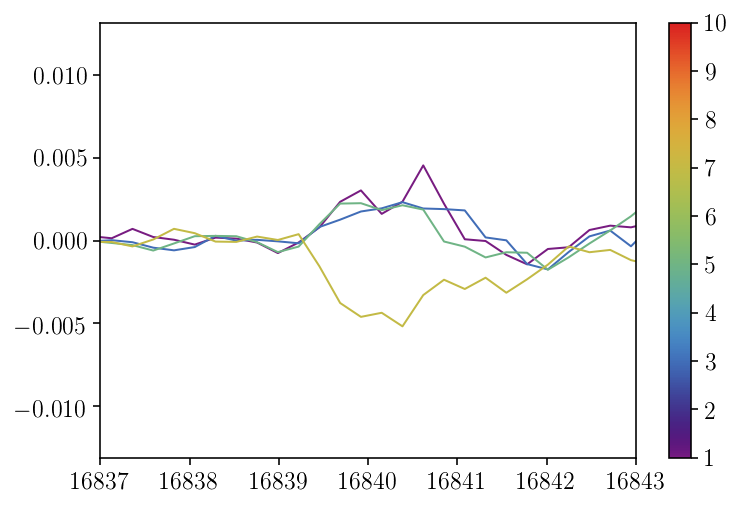

In [21]:
import matplotlib
norm = matplotlib.colors.Normalize(
    vmin=1,
    vmax=10)

# choose a colormap
c_m = matplotlib.cm.viridis

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=cm_rainbow, norm=norm)
s_m.set_array([]) 



agebins = np.arange(0.,10.,2.)
print(agebins)
for i in range(len(agebins)-1):
    agemask = (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] > agebins[i]) & (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] < agebins[i+1]) 
    age = (agebins[i]+agebins[i+1])/2.
    sp = np.nanmedian(pr[agemask][:20], axis=0)
    blue, green, red = chips_split(sp, dr=14)
    blue, green, red = blue[0], green[0], red[0]
    plt.plot(lambda_blue, blue, c=s_m.to_rgba(age))
    plt.plot(lambda_green, green, c=s_m.to_rgba(age))
    plt.plot(lambda_red, red, c=s_m.to_rgba(age))

    
#lines = splot._CO_lines
#for l in lines:
#    plt.axvline(l, color=cols[1], lw=1.,zorder=1)
#lines = splot._CN_lines
#for l in lines:
#    plt.axvline(l, color=cols[0], lw=1.,zorder=1)
    

plt.colorbar(s_m)
plt.xlim(16837,16843)

[0. 2. 4. 6. 8.]


(15100, 15500)

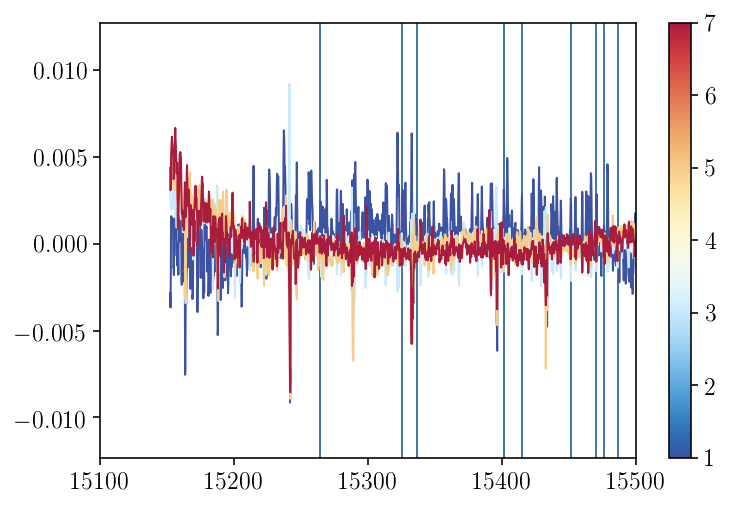

In [177]:
import matplotlib
norm = matplotlib.colors.Normalize(
    vmin=1,
    vmax=7)

# choose a colormap
c_m = matplotlib.cm.viridis

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=cm_diverging, norm=norm)
s_m.set_array([]) 

absorps =[]

agebins = np.arange(0.,10.,2.)
print(agebins)
for i in range(len(agebins)-1):
    agemask = (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] > agebins[i]) & (ndata['APOKASC2_AGE'][idx_2][mask][~test_mask][snrmask] < agebins[i+1]) 
    age = (agebins[i]+agebins[i+1])/2.
    sp = np.nanmedian(pr[agemask][:20], axis=0)
    blue, green, red = chips_split(sp, dr=14)
    blue, green, red = blue[0], green[0], red[0]
    plt.plot(lambda_blue, blue, c=s_m.to_rgba(age))
    plt.plot(lambda_green, green, c=s_m.to_rgba(age))
    plt.plot(lambda_red, red, c=s_m.to_rgba(age))
    absorps.append(np.sum(sp*Ndf))
    
lines = splot._CO_lines
for l in lines:
    plt.axvline(l, color=cols[1], lw=1.,zorder=1)
lines = splot._CN_lines
for l in lines:
    plt.axvline(l, color=cols[0], lw=1.,zorder=1)
    

plt.colorbar(s_m)
plt.xlim(15100,15500)

In [137]:
from astroNN.apogee.plotting import aspcap_windows_url_correction
import pandas as pd
from urllib.request import urlopen
url = f"https://svn.sdss.org/public/repo/apogee/idlwrap/trunk/lib/l31c/" \
      f"{aspcap_windows_url_correction('N')}.mask"
Cdf = np.array(pd.read_csv(urlopen(url), header=None, sep='\t'))
url = f"https://svn.sdss.org/public/repo/apogee/idlwrap/trunk/lib/l31c/" \
      f"{aspcap_windows_url_correction('C')}.mask"
Ndf = np.array(pd.read_csv(urlopen(url), header=None, sep='\t'))
url = f"https://svn.sdss.org/public/repo/apogee/idlwrap/trunk/lib/l31c/" \
      f"{aspcap_windows_url_correction('Mg')}.mask"
Mgdf = np.array(pd.read_csv(urlopen(url), header=None, sep='\t'))
url = f"https://svn.sdss.org/public/repo/apogee/idlwrap/trunk/lib/l31c/" \
      f"{aspcap_windows_url_correction('CI')}.mask"
CIdf = np.array(pd.read_csv(urlopen(url), header=None, sep='\t'))
url = f"https://svn.sdss.org/public/repo/apogee/idlwrap/trunk/lib/l31c/" \
      f"{aspcap_windows_url_correction('Fe')}.mask"
Fedf = np.array(pd.read_csv(urlopen(url), header=None, sep='\t'))

In [150]:
window=CIdf
CIwinmask = window.flatten() > 0.

window=Mgdf
Mgwinmask = window.flatten() > 0.

window=Fedf
Fewinmask = window.flatten() > 0.

window=Ndf
Nwinmask = window.flatten() > 0.

window=Cdf
Cwinmask = window.flatten() > 0.

In [95]:
old = agemask = (ndata['APOKASC2_AGE'][idx_2][mask] > 10.) & (ndata['APOKASC2_AGE'][idx_2][mask] < 14) 
old_jacobian_array = bcnn_net.jacobian(test_spec[mask][old], mean_output=True)
young = agemask = (ndata['APOKASC2_AGE'][idx_2][mask] > 0.) & (ndata['APOKASC2_AGE'][idx_2][mask] < 2.) 
young_jacobian_array = bcnn_net.jacobian(test_spec[mask][young], mean_output=True)

Finished all gradient calculation, 4.50 seconds elapsed
Finished all gradient calculation, 18.00 seconds elapsed


(-0.25, 0.12)

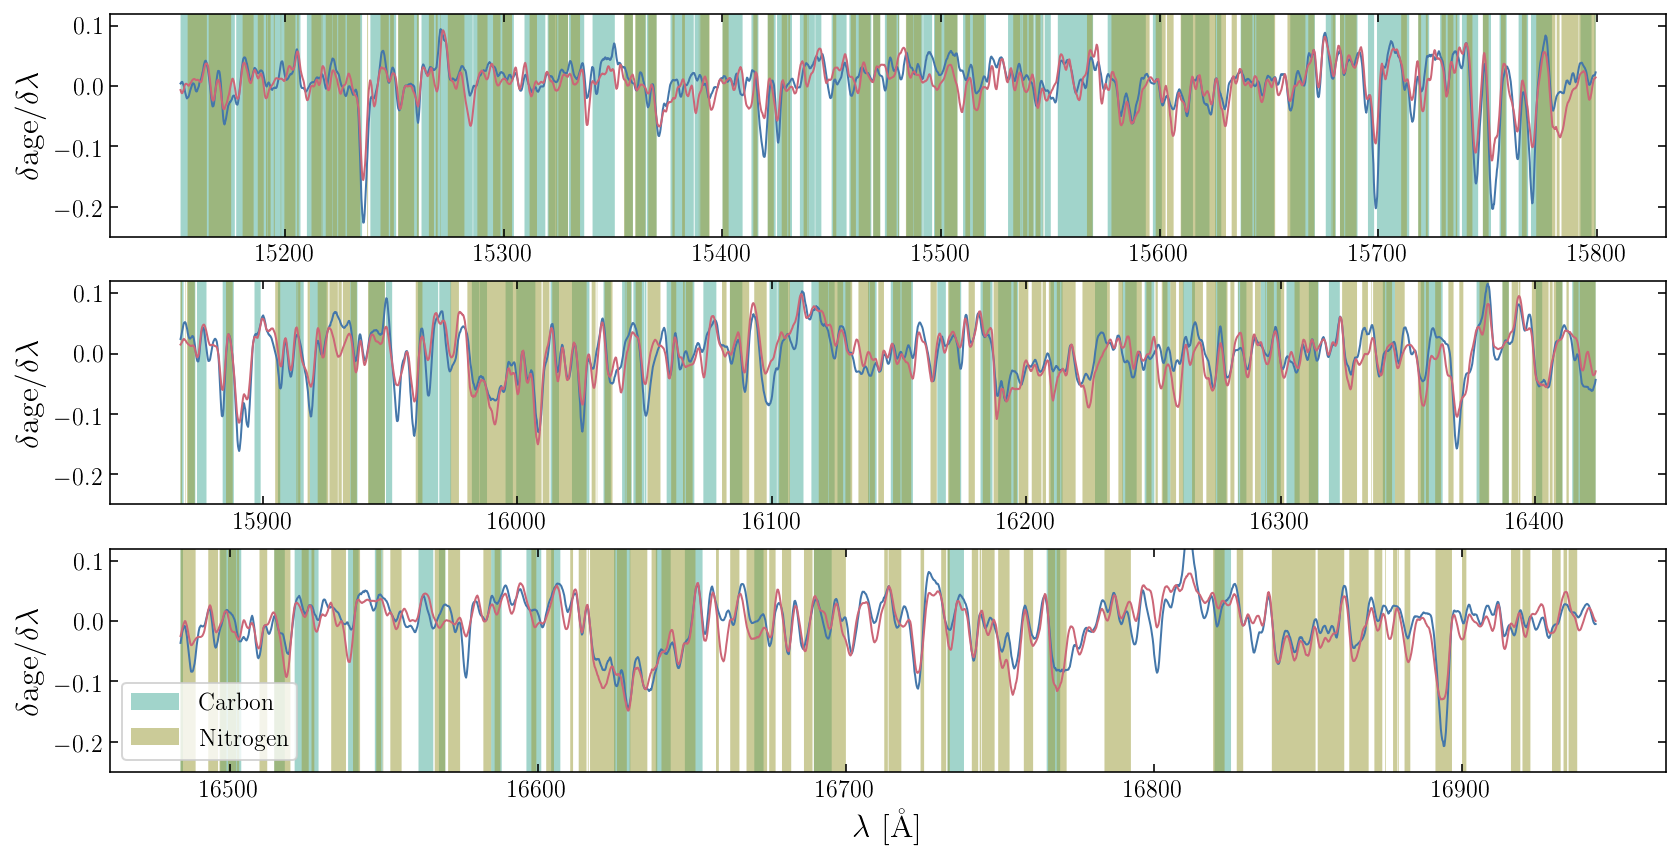

In [151]:
fig, ax = plt.subplots(3,1, sharey=True)
fig.set_size_inches(2*textwidth, textwidth)
#sp = np.nanmedian(pr[agemask][:20], axis=0)
blue, green, red = chips_split(old_jacobian_array[0,:], dr=14)
ax[0].plot(lambda_blue, blue[0], color=cols[0])
ax[1].plot(lambda_green, green[0], color=cols[0])
ax[2].plot(lambda_red, red[0], color=cols[0])
blue, green, red = chips_split(young_jacobian_array[0,:], dr=14)
ax[0].plot(lambda_blue, blue[0], color=cols[1])
ax[1].plot(lambda_green, green[0], color=cols[1])
ax[2].plot(lambda_red, red[0], color=cols[1])

win = np.zeros(len(CIwinmask))
win[CIwinmask] = 10.
win[~CIwinmask] = -10
blue, green, red = chips_split(win, dr=14)

ax[0].fill_between(lambda_blue, blue[0], np.ones(len(blue))*-10, alpha=0.5, color=col_dict['turquoise'], lw=0.)
ax[1].fill_between(lambda_green, green[0], np.ones(len(green))*-10, alpha=0.5, color=col_dict['turquoise'], lw=0.)
ax[2].fill_between(lambda_red, red[0], np.ones(len(red))*-10, alpha=0.5, color=col_dict['turquoise'], lw=0., label=r'$\mathrm{Carbon}$')

win = np.zeros(len(Mgwinmask))
win[Mgwinmask] = 10.
win[~Nwinmask] = -10
blue, green, red = chips_split(win, dr=14)

ax[0].fill_between(lambda_blue, blue[0], np.ones(len(blue))*-10, alpha=0.5, color=col_dict['olive'], lw=0.)
ax[1].fill_between(lambda_green, green[0], np.ones(len(green))*-10, alpha=0.5, color=col_dict['olive'], lw=0.)
ax[2].fill_between(lambda_red, red[0], np.ones(len(red))*-10, alpha=0.5, color=col_dict['olive'], lw=0., label=r'$\mathrm{Nitrogen}$')

ax[2].legend()
#win = np.zeros(len(Fewinmask))
#win[Fewinmask] = 10.
#win[~Fewinmask] = -10
#blue, green, red = chips_split(win, dr=14)
#
#ax[0].fill_between(lambda_blue, blue[0], np.ones(len(blue))*-10, alpha=0.3, color=col_dict['maroon'], lw=0.)
#ax[1].fill_between(lambda_green, green[0], np.ones(len(green))*-10, alpha=0.3, color=col_dict['maroon'], lw=0.)
#ax[2].fill_between(lambda_red, red[0], np.ones(len(red))*-10, alpha=0.3, color=col_dict['maroon'], lw=0.)
ax[0].set_ylabel(r'$\delta\mathrm{age}/\delta \lambda$')
ax[1].set_ylabel(r'$\delta\mathrm{age}/\delta \lambda$')
ax[2].set_ylabel(r'$\delta\mathrm{age}/\delta \lambda$')
ax[2].set_xlabel(r'$\lambda\ \mathrm{[\AA]}$')
plt.ylim(-0.25,0.12)

In [20]:
from astroNN.apogee.plotting import aspcap_windows_url_correction
import pandas as pd
from urllib.request import urlopen
url = f"https://svn.sdss.org/public/repo/apogee/idlwrap/trunk/lib/l31c/" \
      f"{aspcap_windows_url_correction('N')}.mask"
Cdf = np.array(pd.read_csv(urlopen(url), header=None, sep='\t'))
url = f"https://svn.sdss.org/public/repo/apogee/idlwrap/trunk/lib/l31c/" \
      f"{aspcap_windows_url_correction('C')}.mask"
Ndf = np.array(pd.read_csv(urlopen(url), header=None, sep='\t'))

In [132]:
np.sum(sp*Cdf)

-2019.3684707217112

/home/astjmack/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



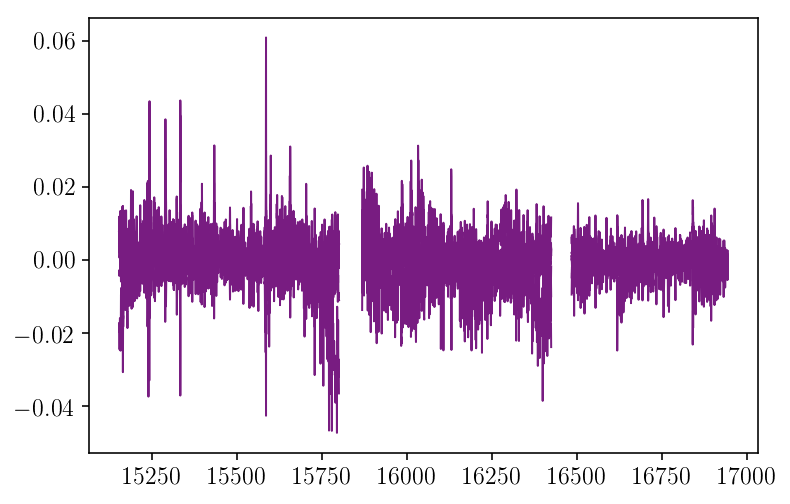

In [141]:
agebins = np.linspace(-0.6,0.2,10)
absorps = []
for i in range(len(agebins)-1):
    agemask = (ndata['C_FE'][idx_2][mask][~test_mask][snrmask] > agebins[i]) & (ndata['C_FE'][idx_2][mask][~test_mask][snrmask] < agebins[i+1]) 
    age = (agebins[i]+agebins[i+1])/2.
    sp = np.nanmedian(pr[agemask][:10], axis=0)
    blue, green, red = chips_split(sp, dr=14)
    blue, green, red = blue[0], green[0], red[0]
    plt.plot(lambda_blue, blue, c=s_m.to_rgba(age))
    plt.plot(lambda_green, green, c=s_m.to_rgba(age))
    plt.plot(lambda_red, red, c=s_m.to_rgba(age))
    absorps.append(np.sum(sp*Ndf))
    

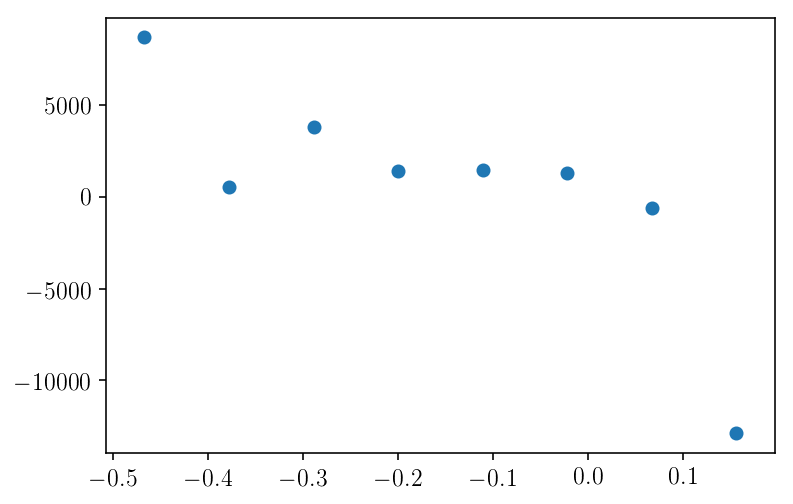

In [142]:
agecent = (agebins[1:]+agebins[:-1])/2.
plt.scatter(agecent,absorps)

In [140]:
absorps

[nan,
 23828.846211234486,
 1934.161702691109,
 638.6132376731379,
 1026.5814752777308,
 -12880.737964173548,
 nan,
 nan,
 nan]